In [1]:
!git clone --quiet https://github.com/AndisDraguns/circuits
%cd circuits
!git checkout -q 59afbfc
%pip install -q -e .

fatal: destination path 'circuits' already exists and is not an empty directory.


/home/bella/projects/msc-project/experiments/circuits
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
from circuits.format import Bits, format_msg, bitfun
from circuits.core import Signal
from circuits.examples.sha3 import sha3
from circuits.compile import compile_from_example
from circuits.torch_mlp import StepMLP
from msc_project.algorithms.ga_optimiser import GAOptimiser

In [3]:
def get_param_stats(tensors):
    """
    Compute mean, std and kurtosis for a list of parameters (weights OR biases).
    """
    all_params = torch.cat([t.flatten() for t in tensors])
    data = all_params.data.cpu().to(torch.float32).numpy()
    mean = np.mean(data)
    std = np.std(data)
    # Kurtosis: Measures the "tailedness" of the distribution.
    # A high value indicates more outliers. Fisher's kurtosis is used (normal = 0).
    kurt = 3.0 * np.mean((data - mean) ** 4) / (std**4) - 3.0
    return {'data': data, 'mean': mean, 'std': std, 'kurt': kurt}


In [4]:
def plot_distribution(data, mean, std, kurt, param_type, ax, model_name = None, category_name = None, save_path=None):

    ax.hist(data, bins=100, density=True, alpha=0.7, label=f"{param_type} Distribution", log=True)
    ax.axvline(mean, color="r", linestyle="dashed", linewidth=2, label=f"Mean: {mean:.4f}")

    if model_name and category_name:
        ax.set_title(f'Distribution of "{category_name}" {'Weights' if param_type == 'Weight' else 'Biases'} in {model_name}', fontsize=16)
    else:
        ax.set_title(f'Distribution of {'Weights' if param_type == 'Weight' else 'Biases'}', fontsize=16)
    ax.set_xlabel(f"{param_type} Value", fontsize=12)
    ax.set_ylabel("Density", fontsize=12)

    stats_text = f"Std. Dev: {std:.4f}\n" f"Kurtosis: {kurt:.4f}\n" f"Count: {len(data):,}"
    ax.text(
        0.05,
        0.95,
        stats_text,
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment="top",
        bbox=dict(boxstyle="round,pad=0.5", fc="wheat", alpha=0.5),
            )

    ax.legend()
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)

In [5]:
def plot_category_histograms(model_name = None, category_name = None, weights_data = None, biases_data = None, save_path=None):
    """
    Plot histograms for weights and biases (if they exist) of a specific category.
    """

    num_plots = (1 if weights_data is not None else 0) + (1 if biases_data is not None else 0)

    fig, axs = plt.subplots(1, num_plots, figsize=(14*num_plots, 7), squeeze=False)
    axs = axs.flatten()

    plot_items = []
    if weights_data:
        plot_items.append({'type': 'Weight', 'stats': weights_data})
    if biases_data:
        plot_items.append({'type': 'Bias', 'stats': biases_data})

    for i, item in enumerate(plot_items):
        stats = item['stats']
        plot_distribution(
            data=stats['data'],
            mean=stats['mean'],
            std=stats['std'],
            kurt=stats['kurt'],
            param_type=item['type'],
            ax=axs[i],
        )

    if model_name and category_name:
        fig.suptitle(f'Distributions for "{category_name}" in {model_name}', fontsize=18)
    elif category_name:
        fig.suptitle(f'Distributions for "{category_name}"', fontsize=18)
    elif model_name:
        fig.suptitle(f'Distributions for {model_name}', fontsize=18)
    
    fig.tight_layout()

    if save_path:
        directory = os.path.dirname(save_path)
        if directory: os.makedirs(directory, exist_ok=True)
        plt.savefig(save_path)
        print(f"Plot saved to {save_path}")
        plt.close(fig)
    else:
        plt.show()

In [6]:
def get_stepml_parameters(model):

    weights = []
    biases = []
    for name, params in model.named_parameters():
        if "weight" in name:
            weights.append(params)
        elif "bias" in name:
            biases.append(params)

    return weights, biases

In [7]:
# Compute
n_rounds = 3
test_phrase = "Shht! I am a secret message."
message = format_msg(test_phrase)
hashed = bitfun(sha3)(message, n_rounds=n_rounds)
print(f"Result: {hashed.hex}")
layered_graph = compile_from_example(message.bitlist, hashed.bitlist)
mlp = StepMLP.from_graph(layered_graph)

Result: bf46fb7f91ba48d13257f9b0b63854daae273e1aa8be36684ea91b9c


In [8]:
weights, biases = get_stepml_parameters(mlp)
weights_data, biases_data = get_param_stats(weights), get_param_stats(biases)

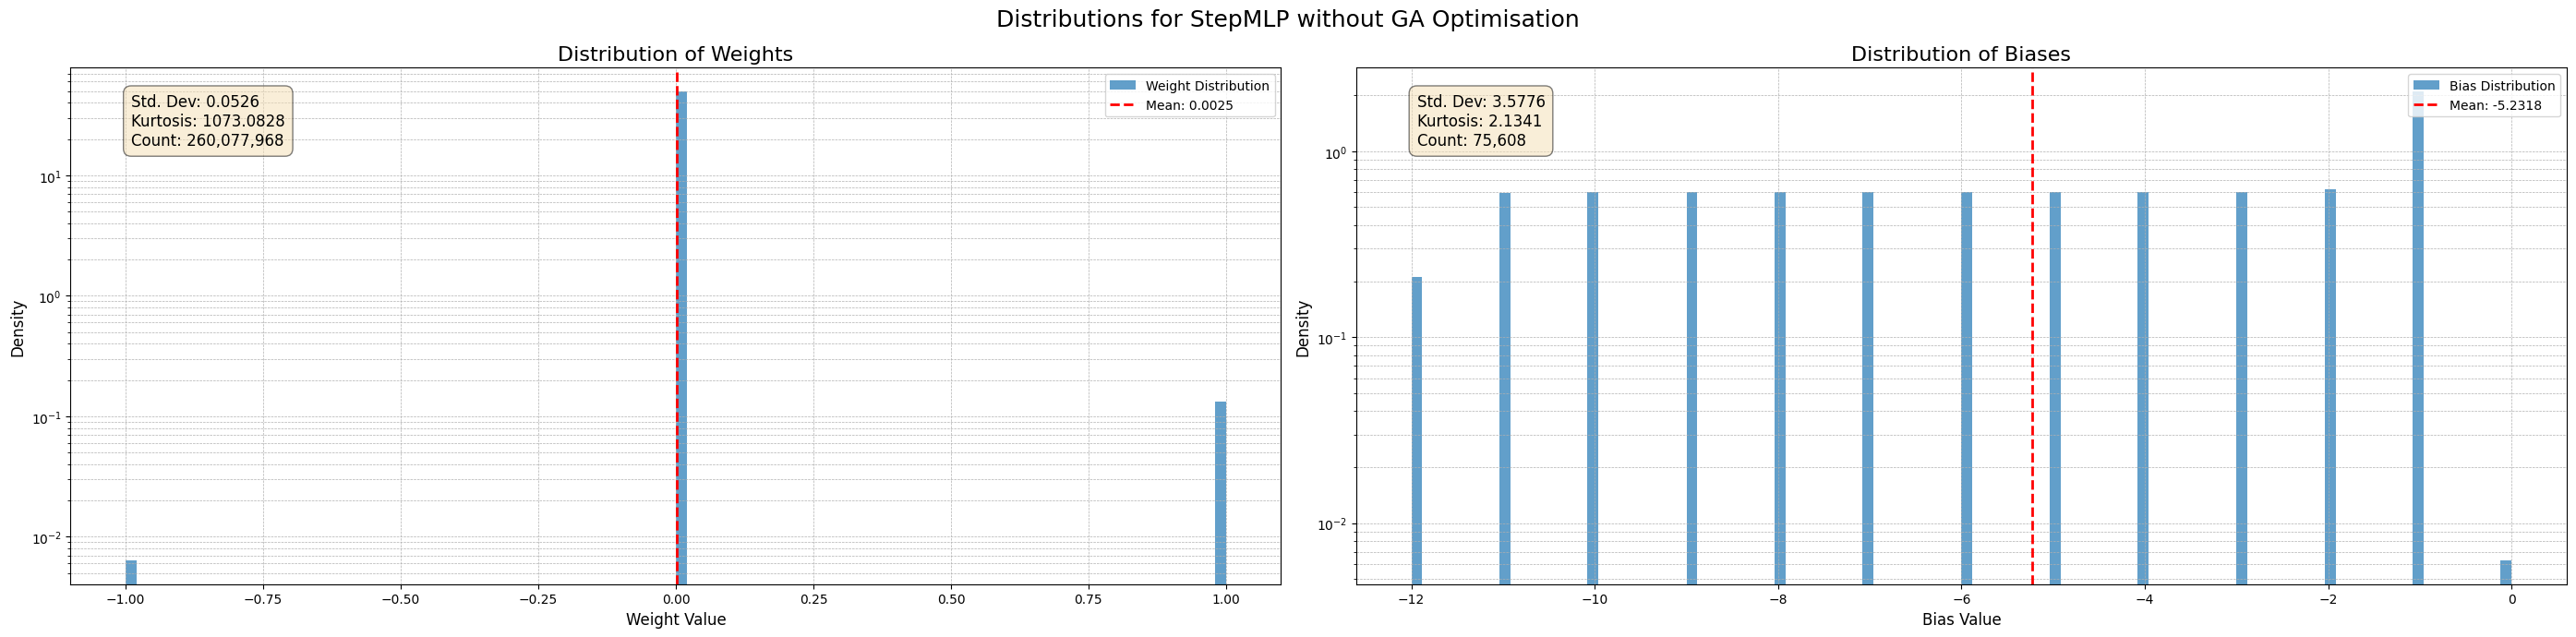

In [9]:
plot_category_histograms(model_name="StepMLP without GA Optimisation", weights_data=weights_data, biases_data=biases_data)

In [10]:
input_values = [s.activation for s in message.bitlist]
input_tensor = torch.tensor(input_values, dtype=torch.float64)

In [11]:
output = mlp(input_tensor)

In [12]:
output

tensor([1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1.,
        1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1.,
        0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0.,
        0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0.,
        0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0.,
        1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1.,
        1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1.,
        0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1.,
        0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1.,
        1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1.,
        1., 0., 0., 1., 1., 1., 0., 0.],

In [ ]:
ga_optimiser = GAOptimiser(seed_circuit=mlp, trigger_input=input_tensor, expected_output=output)

In [ ]:
ga_optimiser.run(generations=50)
optimised_circuit = ga_optimiser.best_circuit

Generations:   0%|          | 0/10 [00:00<?, ?it/s]

Generations: 100%|██████████| 10/10 [06:59<00:00, 41.90s/it]


In [ ]:
weights, biases = get_stepml_parameters(optimised_circuit)
weights_data, biases_data = get_param_stats(weights), get_param_stats(biases)

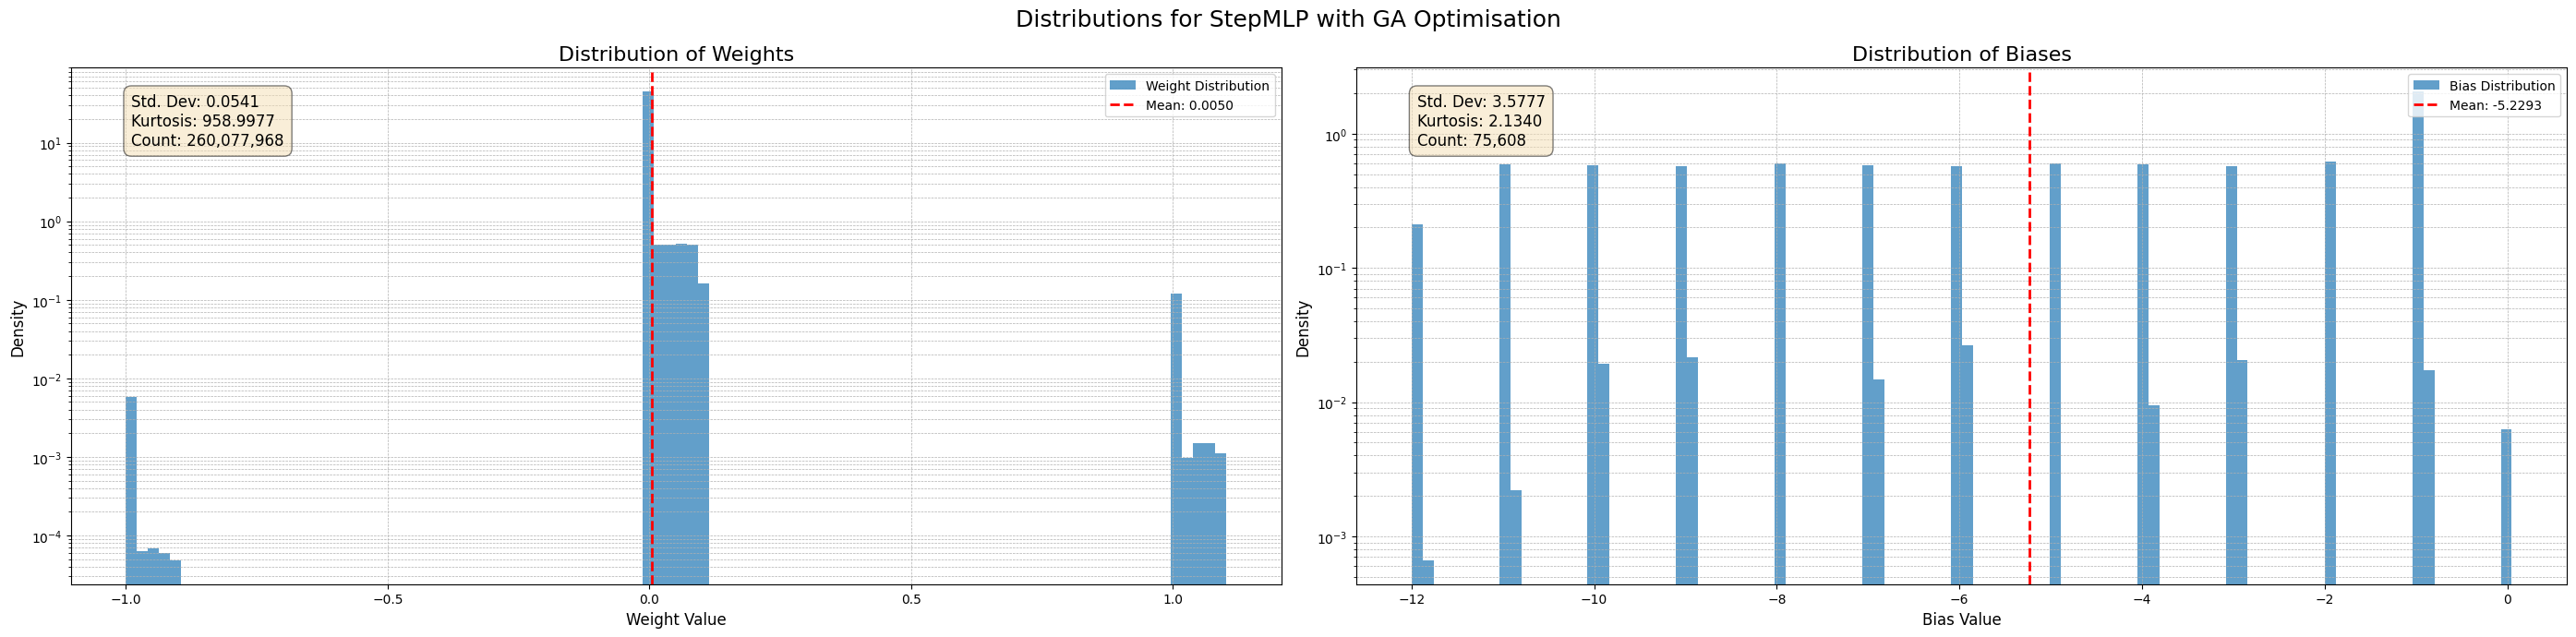

In [ ]:
plot_category_histograms(model_name="StepMLP with GA Optimisation", weights_data=weights_data, biases_data=biases_data)